# Project Introduction - Customer Segmentation (Part 2)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the __data preparation__: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook only handles part 2.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from joblib import dump

# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 2: Customer Segmentation (Unsupervised Learning)
In this section we will try to understand which parts of the customers' dataset are overrepresented or underrepresented in the population dataset with the goal of identifying the types of customers the company should target. This will be done by clustering both datasets and comparing the distributions of the clusters. Since we have almost 50 columns, it is a good idea to reduce the complexity of the problem to avoid redundancy and overfitting issues.

The approach looks like this:
1.	Reduce the dimensionality using PCA to a certain `n` number of components that explain a reasonable amount of the variance for each type of columns.
2.	Find the top 20 features which have the most impact on the total components so we can use them to understand customer segments.
3.	Find a `k` number of clusters for the `n` components of the population data using common methods of analysis and use the best fitting `k` to cluster the customer dataset.
4.	Compare the distribution of the clusters for the population with the customers’ dataset and see which ones are overrepresented or underrepresented.
5.	Make a centroid analysis of the clusters using for top 20 features to understand the types of customers the company should target or avoid.
6.  Analyze the results and deploy the clustering model to use in part 3.


In [2]:
# Load the cleaned data for the customer segmentation part
population_df = pd.read_csv('data\\Cleaned_Udacity_AZDIAS_052018.csv', sep=';')
customers_df = pd.read_csv('data\\Cleaned_Udacity_CUSTOMERS_052018.csv', sep=';')

# Load the attributes df
attributes_df = pd.read_excel('data-dictionary\\DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4], skiprows=1)
attributes_df = attributes_df.fillna(method="ffill")
attributes_nms = list(attributes_df["Attribute"].unique())

# Load the attributes df
info_level_df = pd.read_excel('data-dictionary\\DIAS Information Levels - Attributes 2017.xlsx', usecols = [1,2], skiprows=1)
info_level_df = info_level_df.fillna(method="ffill")

In [3]:
population_df.shape

(613991, 508)

## 1.1 Dimensionality Reduction
We will use PCA and plot the cumulative explained variance ratio to understand which components explain a significant amount of the variance while at the same time reducing the complexity of the data. Since this is a complex dataset we can use the different levels of information for the groups of columns using the file `DIAS Information Levels - Values 2017.xlsx`.

Because we want to understand customer segments we can adjust threshold for explainability to the information level. For instance, we may want to capture more information about personal data rather than about the number of cars owned in a particular residence area. This should be done together with a domain expert, but I decided to set the thresholds like this:

| Information Level   | Threshold | Weight |
|---------------------|-----------|--------|
| Person              | 80%       | 26%    |
| Household           | 60%       | 19%    |
| Microcell           | 50%       | 16%    |
| PLZ8                | 50%       | 16%    |
| Rest                | 70%       | 23%    |

In [4]:
population_cols = population_df.columns.copy()

In [5]:
# Get list of columns for information level: Household
info_level_hh_cols = info_level_df[info_level_df["Information level"].isin(["Household","Building"])]["Attribute"].tolist()
hh_cols = [col for col in info_level_hh_cols if col in population_cols]
additional_hh_cols = [col for col in population_cols if re.search("D19_|WOHNLAGE_|GEBAEUDETYP_|MIN_GEBAEUDEJAHR_RTV17", col)]
hh_cols = list(set(hh_cols + additional_hh_cols))
population_cols = list(set(population_cols) - set(hh_cols))
print(hh_cols)

['D19_BANKEN_REST', 'D19_KOSMETIK', 'D19_RATGEBER', 'KONSUMNAEHE', 'D19_BANKEN_DATUM', 'D19_HANDWERK', 'WOHNLAGE_0.0', 'D19_GESAMT_OFFLINE_DATUM', 'D19_SCHUHE', 'D19_VERSI_ANZ_12', 'D19_BANKEN_GROSS', 'D19_VOLLSORTIMENT', 'D19_TELKO_ANZ_12', 'D19_VERSAND_DATUM', 'ANZ_HH_TITEL', 'ANZ_HAUSHALTE_AKTIV', 'D19_VERSAND_ONLINE_QUOTE_12', 'ALTER_HH', 'D19_DROGERIEARTIKEL', 'D19_REISEN', 'D19_VERSAND_ANZ_12', 'D19_HAUS_DEKO', 'WOHNLAGE_1.0', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BEKLEIDUNG_REST', 'D19_TELKO_OFFLINE_DATUM', 'D19_BUCH_CD', 'WOHNLAGE_4.0', 'D19_SAMMELARTIKEL', 'D19_VERSI_DATUM', 'D19_SONSTIGE', 'D19_KONSUMTYP_MAX', 'GEBAEUDETYP_1.0', 'D19_TECHNIK', 'D19_VERSAND_REST', 'GEBAEUDETYP_6.0', 'GEBAEUDETYP_RASTER', 'D19_BANKEN_DIREKT', 'GEBAEUDETYP_2.0', 'D19_BANKEN_LOKAL', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_DATUM', 'D19_BILDUNG', 'GEBAEUDETYP_3.0', 'D19_DIGIT_SERV', 'D19_BANKEN_ONLINE_QUOTE_12', 'WOHNLAGE_7.0', 'D19_TELKO_MOBILE', 'D19_BANKEN_ONLINE_DATUM', 'D19_SOZIALES', 'D1

In [6]:
# Get list of columns for information level: Person
info_level_person_cols = info_level_df[info_level_df["Information level"] == "Person"]["Attribute"].tolist()
person_cols = [col for col in info_level_person_cols if col in population_cols]
additional_person_cols = [col for col in population_cols if re.search("LP_|TYP_|EINGEZOGENAM_HH_JAHR_RTV17|KZ_", col)]
person_cols = list(set(person_cols + additional_person_cols))
population_cols = list(set(population_cols) - set(person_cols))
print(person_cols)

['LP_LEBENSPHASE_FEIN_24.0', 'GFK_URLAUBERTYP_2.0', 'FINANZTYP_2', 'LP_LEBENSPHASE_FEIN_17.0', 'LP_LEBENSPHASE_FEIN_35.0', 'LP_LEBENSPHASE_FEIN_0.0', 'GFK_URLAUBERTYP_10.0', 'LP_FAMILIE_FEIN_8.0', 'LP_FAMILIE_FEIN_9.0', 'ZABEOTYP_5', 'LP_LEBENSPHASE_FEIN_36.0', 'LP_LEBENSPHASE_FEIN_32.0', 'SHOPPER_TYP_0', 'ZABEOTYP_1', 'ANREDE_KZ_2', 'NATIONALITAET_KZ_2', 'CJT_GESAMTTYP_3.0', 'LP_FAMILIE_FEIN_4.0', 'OST_WEST_KZ_0', 'CJT_GESAMTTYP_2.0', 'AGER_TYP_0', 'LP_LEBENSPHASE_FEIN_10.0', 'SEMIO_DOM', 'RETOURTYP_BK_S_5.0', 'SEMIO_REL', 'LP_STATUS_FEIN_8.0', 'EINGEZOGENAM_HH_JAHR_RTV17', 'LP_STATUS_FEIN_3.0', 'LP_FAMILIE_FEIN_5.0', 'RETOURTYP_BK_S_1.0', 'SEMIO_VERT', 'SEMIO_PFLICHT', 'LP_LEBENSPHASE_FEIN_27.0', 'GFK_URLAUBERTYP_6.0', 'LP_LEBENSPHASE_FEIN_25.0', 'LP_LEBENSPHASE_FEIN_28.0', 'LP_STATUS_FEIN_9.0', 'LP_STATUS_FEIN_6.0', 'LP_LEBENSPHASE_FEIN_2.0', 'FINANZ_VORSORGER', 'SHOPPER_TYP_1', 'LP_STATUS_FEIN_5.0', 'CJT_GESAMTTYP_5.0', 'LP_LEBENSPHASE_FEIN_13.0', 'CJT_GESAMTTYP_1.0', 'GFK_URLAUBER

In [7]:
# Get list of columns for information level: Microcell
info_level_microcell_cols = info_level_df[info_level_df["Information level"] == "Microcell (RR3_ID)"]["Attribute"].tolist()
microcell_cols = [col for col in info_level_microcell_cols if col in population_cols]
additional_microcell_cols = [col for col in population_cols if "KBA05_" in col]
microcell_cols = list(set(microcell_cols + additional_microcell_cols))
population_cols = list(set(population_cols) - set(microcell_cols))
print(microcell_cols)

['KBA05_MAXHERST_-1.0', 'KBA05_ANTG1', 'KBA05_SEG8', 'KBA05_HERST5', 'KBA05_HERST3', 'KBA05_HERSTTEMP_9.0', 'KBA05_MOD4', 'KBA05_MAXAH', 'KBA05_HERSTTEMP_1.0', 'KBA05_MODTEMP_6.0', 'KBA05_HERST1', 'KBA05_KRSHERST1', 'KBA05_MODTEMP_4.0', 'KBA05_CCM2', 'KBA05_MOD1', 'KBA05_MAXBJ', 'KBA05_MODTEMP_5.0', 'KBA05_SEG4', 'KBA05_ANTG3', 'KBA05_MAXHERST_1.0', 'KBA05_KRSZUL', 'KBA05_SEG5', 'KBA05_HERSTTEMP_2.0', 'KBA05_ZUL1', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_ALTER3', 'KBA05_ALTER2', 'KBA05_MOD3', 'KBA05_MAXHERST_3.0', 'KBA05_MAXHERST_2.0', 'KBA05_MAXHERST_4.0', 'KBA05_ANTG2', 'KBA05_SEG9', 'KBA05_HERSTTEMP_3.0', 'KBA05_MOTRAD', 'KBA05_KW2', 'KBA05_SEG2', 'KBA05_ALTER4', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_MAXVORB', 'KBA05_SEG7', 'KBA05_HERSTTEMP_4.0', 'KBA05_AUTOQUOT', 'KBA05_KW1', 'KBA05_KRSAQUOT', 'KBA05_MODTEMP_1.0', 'KBA05_ZUL4', 'KBA05_ZUL3', 'KBA05_KRSHERST2', 'KBA05_ZUL2', 'KBA05_VORB1', 'KBA05_MAXSEG', 'KBA05_GBZ', 'KBA05_HERSTTEMP_5.0', 'KBA05_CCM4', 'KBA05_MOD8', 'KBA05_VORB2',

In [8]:
# Get list of columns for information level: PLZ8
info_level_PLZ8_cols = info_level_df[info_level_df["Information level"] == "PLZ8"]["Attribute"].tolist()
PLZ8_cols = [col for col in info_level_PLZ8_cols if col in population_cols]
additional_PLZ8_cols = [col for col in population_cols if "PLZ8_" in col]
PLZ8_cols = list(set(PLZ8_cols + additional_PLZ8_cols))
population_cols = list(set(population_cols) - set(PLZ8_cols))
print(PLZ8_cols)

['KBA13_HERST_BMW_BENZ', 'KBA13_FAB_SONSTIGE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_OPEL', 'KBA13_KW_110', 'KBA13_MERCEDES', 'KBA13_ALTERHALTER_60', 'KBA13_HALTER_35', 'KBA13_HERST_AUDI_VW', 'KBA13_CCM_1400', 'KBA13_RENAULT', 'KBA13_ALTERHALTER_61', 'PLZ8_BAUMAX_3.0', 'KBA13_VORB_0', 'KBA13_HALTER_40', 'PLZ8_ANTG1', 'KBA13_KRSSEG_VAN', 'KBA13_FAB_ASIEN', 'KBA13_KW_80', 'PLZ8_ANTG3', 'KBA13_KW_30', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_BJ_2000', 'KBA13_HERST_FORD_OPEL', 'KBA13_HERST_ASIEN', 'KBA13_CCM_2500', 'KBA13_KW_60', 'KBA13_HALTER_25', 'KBA13_AUTOQUOTE', 'KBA13_HALTER_66', 'KBA13_SITZE_6', 'KBA13_HALTER_50', 'KBA13_KMH_250', 'PLZ8_BAUMAX_1.0', 'KBA13_HALTER_55', 'KBA13_CCM_1600', 'KBA13_CCM_2501', 'KBA13_AUDI', 'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_KRSSEG_KLEIN', 'KBA13_KW_40', 'KBA13_KW_61_120', 'KBA13_KRSSEG_OBER', 'KBA13_BJ_2006', 'KBA13_HERST_SONST', 'KBA13_VORB_1', 'KBA13_ALTERHALTER_30', 'KBA13_BJ_2008', 'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_KW_0_60', 'KBA13_VORB_3

In [9]:
# Get list of columns for information level: Rest
rest_cols = population_cols.copy()
print(rest_cols)

['CAMEO_DEU_2015_2A', 'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_34', 'CAMEO_DEU_2015_2D', 'CAMEO_INTL_2015_55', 'MOBI_REGIO', 'CAMEO_INTL_2015_41', 'CAMEO_DEU_2015_5E', 'CAMEO_INTL_2015_XX', 'CAMEO_INTL_2015_14', 'CAMEO_DEU_2015_4B', 'RELAT_AB', 'CAMEO_DEU_2015_4E', 'KBA13_CCM_3000', 'CAMEO_DEU_2015_6C', 'CAMEO_DEU_2015_5A', 'CAMEO_INTL_2015_44', 'CAMEO_DEU_2015_4C', 'CAMEO_DEU_2015_3A', 'CAMEO_DEU_2015_5D', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015_1A', 'CAMEO_INTL_2015_12', 'INNENSTADT', 'CAMEO_DEU_2015_5B', 'CAMEO_DEU_2015_6B', 'CAMEO_DEU_2015_8C', 'CAMEO_INTL_2015_22', 'ORTSGR_KLS9', 'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_1E', 'CAMEO_INTL_2015_31', 'KKK', 'CAMEO_DEU_2015_3C', 'CAMEO_DEU_2015_7E', 'CAMEO_INTL_2015_25', 'CAMEO_INTL_2015_15', 'EWDICHTE', 'CAMEO_DEU_2015_6D', 'CAMEO_INTL_2015_33', 'CAMEO_DEU_2015_7D', 'CAMEO_DEU_2015_1B', 'CAMEO_DEU_2015_6E', 'REGIOTYP', 'CAMEO_DEU_2015_7B', 'CAMEO_DEU_2015_4A', 'CAMEO_DEU_2015_4D', 'CAMEO_DEU_2015_7A', 'BALLRAUM', 'CAMEO_DEU_2015_8B', 'CAMEO_DEU_

In [10]:
def plot_pca(df, column_list, df_name, threshold):
    """
    This function plots the cumulative explained variance using PCA for a particular threshold of explained variance. 
    It takes in as arguments a dataset, the list of columns, the name of the dataset and a threshold to find the number of components for that explained variance.
    """
    # Step 1: Select the data
    df = df[column_list]
    
    # Step 2: Fit a standard PCA to find the n components
    pca = PCA(random_state=101)
    pca_result = pca.fit_transform(df)

    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    n_components_for_threshold = np.where(cum_explained_variance >= threshold)[0][0]
    
    # Step 3 - Plot the Cumulative Explained Variances
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 2)
    plt.plot(range(len(explained_variance)), cum_explained_variance)
    plt.ylabel('Cumulative explained variance ratio')
    plt.xlabel('Number of components')
    plt.title(f'Cumulative Explained Variance Plot for the {df_name}')
    plt.axhline(y=threshold, color='grey', linestyle='--', label=f'Threshold at {threshold}') 

    plt.annotate(text = f"{n_components_for_threshold} components explain\n{round(threshold*100)}% of the variance.",
                 xy = (n_components_for_threshold, threshold),
                 xytext = (n_components_for_threshold, threshold-0.1),
                 arrowprops=dict(arrowstyle='->'))

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show(); 

In [11]:
# Scale the population dataset before applying PCA
sc = StandardScaler()
scaled_population_array = sc.fit_transform(population_df)
scaled_population_df = pd.DataFrame(scaled_population_array, columns=population_df.columns)
scaled_population_df.head()

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,...,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_

__Information level__: Person

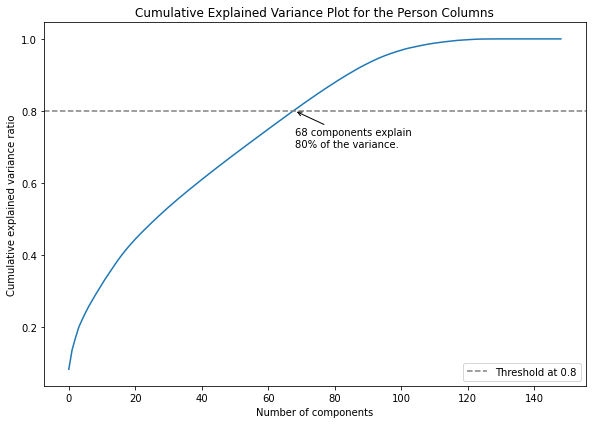

In [12]:
plot_pca(scaled_population_df, person_cols, "Person Columns", 0.8)

__Information level__: Household

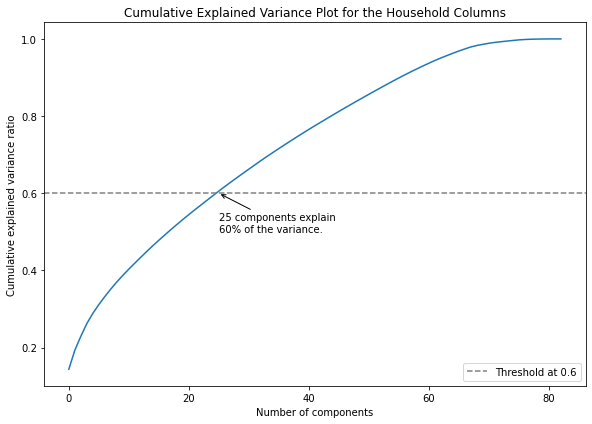

In [13]:
plot_pca(scaled_population_df, hh_cols, "Household Columns", 0.6)

__Information level__: Microcell

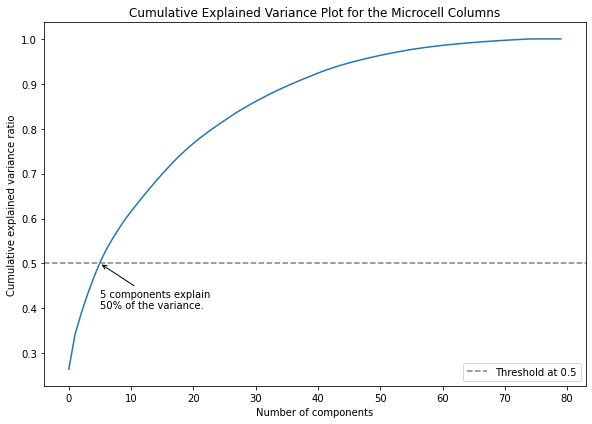

In [14]:
plot_pca(scaled_population_df, microcell_cols, "Microcell Columns", 0.5)

__Information level__: PLZ8

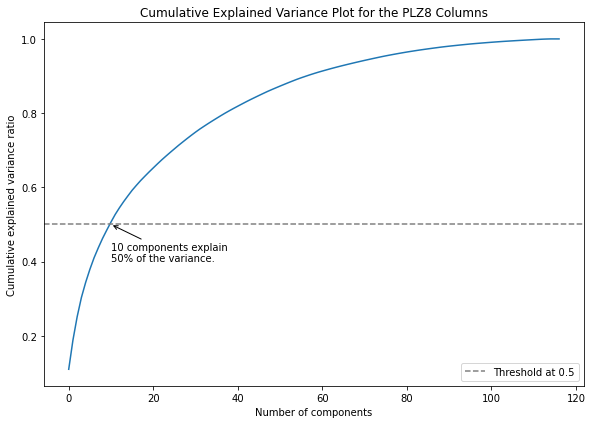

In [15]:
plot_pca(scaled_population_df, PLZ8_cols, "PLZ8 Columns", 0.5)

__Information level__: Rest

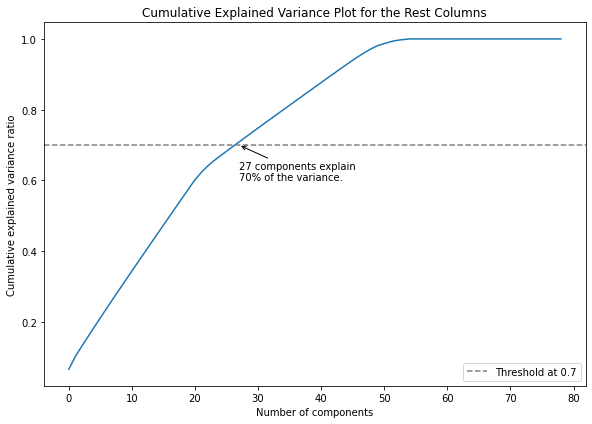

In [16]:
plot_pca(scaled_population_df, rest_cols, "Rest Columns", 0.7)

__Analysis__: Based on the graphics above we can reduce the initial 508 columns to __135 components__ and still keep a big part of the variance for the parts that interest us the most.

 The next step now would be to understand which features are being more important to explain variance of the data. One way to do this would be to look at the first principal component and then the second, which is something that we see a lot in literature. However, these first components would not be enough to capture the bigger picture of each information level.

I decided to build a list of the __20 most influential features__ to use for the customer segmentation analysis. The idea was to get the top `m` most influential features for information level. The idea is to pick a certain number of `m` depending on the weight that the particular information level has in relation to the rest - for example since the Person group accounts for 26% of the importance then 5 features from this group would be included in the top 20.

One way to find the most important features for information level can look like this: For each principal component of a number `n` of principal components we take the top 10 most influential and add them to a list. Each time the same feature appears it gets added by 1. At the end of the `nth` principal component we select the corresponding number `m` of top features and include them to the final top 20 list. Finding the ideal value of `n` principal components for each information level can be done by applying an elbow method of the Scree Plot using the explained variance ratio.

In [17]:
# Fit the PCA with identified numbers of components for each information level

# Information level: Person
pca_person = PCA(n_components=68, random_state=101)
pca_person_array = pca_person.fit_transform(scaled_population_df[person_cols])

explained_variance_person = pca_person.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Household
pca_hh = PCA(n_components=25, random_state=101)
pca_hh_array = pca_hh.fit_transform(scaled_population_df[hh_cols])

explained_variance_hh = pca_hh.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Microcell
pca_microcell = PCA(n_components=5, random_state=101)
pca_microcell_array = pca_microcell.fit_transform(scaled_population_df[microcell_cols])

explained_variance_microcell = pca_microcell.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: PLZ8
pca_PLZ8 = PCA(n_components=10, random_state=101)
pca_PLZ8_array = pca_PLZ8.fit_transform(scaled_population_df[PLZ8_cols])

explained_variance_PLZ8 = pca_PLZ8.explained_variance_ratio_

#-----------------------------------------------------------------------------

# Information level: Rest
pca_rest = PCA(n_components=27, random_state=101)
pca_rest_array = pca_rest.fit_transform(scaled_population_df[rest_cols])

explained_variance_rest = pca_rest.explained_variance_ratio_

In [18]:
def plot_scree_plot(explained_variance, information_level, component_number):
    plt.figure(figsize=(20,5))
    
    # Adjust the x-values to start from 1
    x_values = range(1, len(explained_variance) + 1)
    
    plt.plot(x_values, explained_variance, alpha=0.5, label='individual explained variance', marker='o')
 
    # Adjust the x-value for the "elbow" point
    plt.plot(component_number, explained_variance[component_number-1], 'ro', label=f"Elbow at the principal component {component_number}")

    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(f'Scree Plot for the {information_level} columns')
    plt.legend()

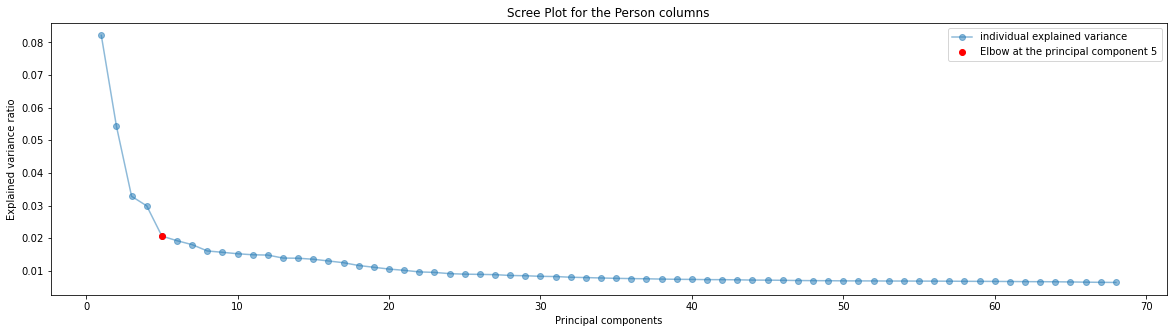

In [19]:
plot_scree_plot(explained_variance_person, "Person", 5)

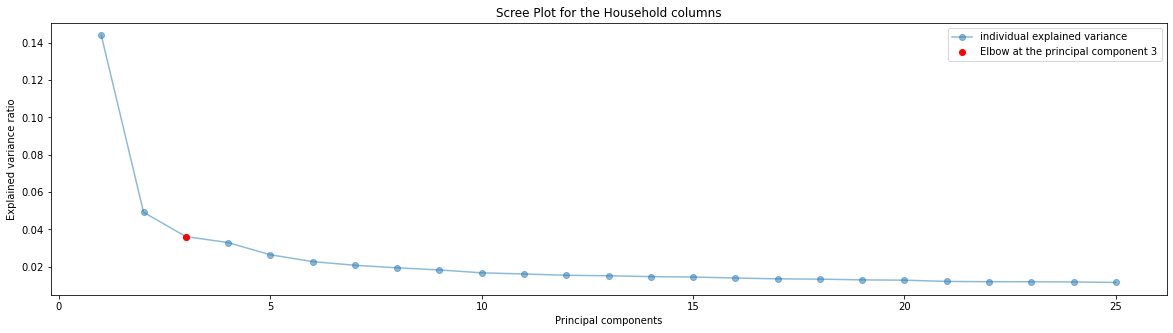

In [20]:
plot_scree_plot(explained_variance_hh, "Household", 3)

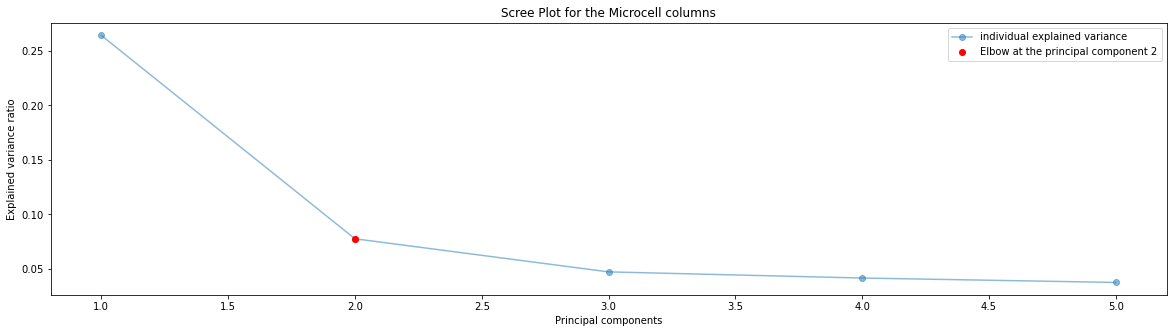

In [21]:
plot_scree_plot(explained_variance_microcell, "Microcell", 2)

Since the elbow is not that pronounced we can just simply use 1 principal component for the feature importance analysis

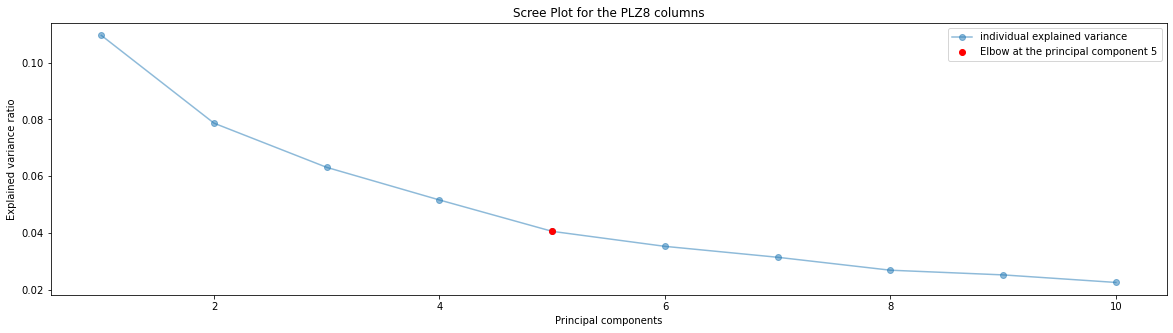

In [22]:
plot_scree_plot(explained_variance_PLZ8, "PLZ8", 5)

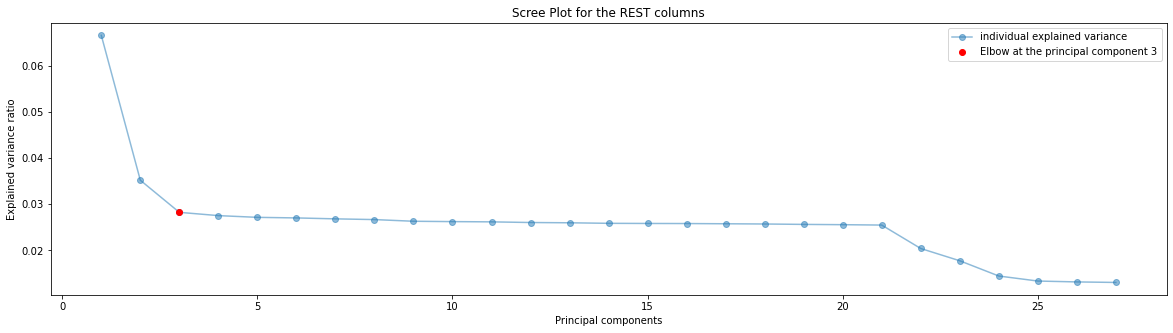

In [23]:
plot_scree_plot(explained_variance_rest, "REST", 3)

In [24]:
def get_top_features(pca, n_components, information_level_cols):
    """
    It prints the most influential features of the list of columns 
    for a PCA instance for a specific number of components based on the information level.
    """
    
    # Instantiate an array of zeros for the number of features 
    feature_counts = np.zeros(len(information_level_cols))

    # For each component of the chosen principal components find the top 10 most influential features and add 1 to the feature counts
    for component in pca.components_[:n_components]:
        top_indices = np.abs(component).argsort()[-10:][::-1]
        feature_counts[top_indices] += 1

    # Create a DataFrame with the feature counts
    feature_counts_df = pd.DataFrame({
        'Feature': information_level_cols,
        'Counts': feature_counts
    })

    # Find the top features
    top_features = feature_counts_df[feature_counts_df["Counts"] > 0].sort_values("Counts", ascending=False)
    
    print(top_features)

In [25]:
# get the most important features for the information level: Person
get_top_features(pca_person, 5, person_cols)

                      Feature  Counts
50        LP_STATUS_FEIN_10.0     3.0
101          GREEN_AVANTGARDE     3.0
144         FINANZ_MINIMALIST     2.0
141        NATIONALITAET_KZ_0     2.0
130          FINANZ_HAUSBAUER     2.0
129             HEALTH_TYP_-1     2.0
67         LP_STATUS_FEIN_1.0     2.0
54                VERS_TYP_-1     2.0
65             SHOPPER_TYP_-1     2.0
120             OST_WEST_KZ_1     1.0
96             FINANZ_ANLEGER     1.0
103                 SEMIO_ERL     1.0
115               AGER_TYP_-1     1.0
14                ANREDE_KZ_2     1.0
121               FINANZTYP_6     1.0
90                  SEMIO_FAM     1.0
125                SEMIO_KAEM     1.0
127       LP_FAMILIE_FEIN_1.0     1.0
128        NATIONALITAET_KZ_1     1.0
132  LP_LEBENSPHASE_FEIN_11.0     1.0
92                 SEMIO_KRIT     1.0
83                ANREDE_KZ_1     1.0
89                  SEMIO_RAT     1.0
39           FINANZ_VORSORGER     1.0
22                  SEMIO_DOM     1.0
24          

In [26]:
# get the most important features for the information level: Household
get_top_features(pca_hh, 3, hh_cols)

                        Feature  Counts
4              D19_BANKEN_DATUM     2.0
20           D19_VERSAND_ANZ_12     2.0
72            D19_BANKEN_ANZ_12     2.0
48      D19_BANKEN_ONLINE_DATUM     2.0
45   D19_BANKEN_ONLINE_QUOTE_12     2.0
40   D19_GESAMT_ONLINE_QUOTE_12     2.0
41     D19_VERSAND_ONLINE_DATUM     2.0
16  D19_VERSAND_ONLINE_QUOTE_12     2.0
13            D19_VERSAND_DATUM     2.0
28            D19_SAMMELARTIKEL     1.0
31            D19_KONSUMTYP_MAX     1.0
19                   D19_REISEN     1.0
5                  D19_HANDWERK     1.0
51            D19_GESAMT_ANZ_12     1.0
57                    D19_LOTTO     1.0
59              D19_TELKO_DATUM     1.0
62      D19_GESAMT_ONLINE_DATUM     1.0
68               WOHNDAUER_2008     1.0
69             D19_GESAMT_DATUM     1.0
7      D19_GESAMT_OFFLINE_DATUM     1.0
77           HH_EINKOMMEN_SCORE     1.0


In [27]:
# get the most important features for the information level: Microcell
get_top_features(pca_microcell, 2, microcell_cols)

                Feature  Counts
61          KBA05_MOTOR     2.0
0   KBA05_MAXHERST_-1.0     1.0
45            KBA05_KW1     1.0
74         KBA05_DIESEL     1.0
73        KBA05_KRSOBER     1.0
70           KBA05_CCM3     1.0
66         KBA05_KRSVAN     1.0
65           KBA05_CCM1     1.0
46       KBA05_KRSAQUOT     1.0
44       KBA05_AUTOQUOT     1.0
10         KBA05_HERST1     1.0
39            KBA05_KW3     1.0
37           KBA05_SEG2     1.0
34  KBA05_HERSTTEMP_3.0     1.0
25       KBA05_KRSKLEIN     1.0
19   KBA05_MAXHERST_1.0     1.0
14           KBA05_MOD1     1.0
11      KBA05_KRSHERST1     1.0
77           KBA05_SEG6     1.0


In [28]:
# get the most important features for the information level: PLZ8
get_top_features(pca_PLZ8, 5, PLZ8_cols)

                         Feature  Counts
50                 KBA13_KW_0_60     2.0
7                KBA13_HALTER_35     2.0
72                 KBA13_SITZE_5     2.0
74               KBA13_HALTER_30     2.0
46          KBA13_ALTERHALTER_30     2.0
0           KBA13_HERST_BMW_BENZ     1.0
79                 KBA13_KMH_140     1.0
53                KBA13_KRSAQUOT     1.0
62                    PLZ8_ANTG2     1.0
65                    PLZ8_ANTG4     1.0
75           KBA13_SEG_MINIWAGEN     1.0
77               KBA13_HALTER_65     1.0
87                      PLZ8_HHZ     1.0
84              KBA13_KRSZUL_NEU     1.0
88               KBA13_HALTER_60     1.0
91               KBA13_HALTER_45     1.0
92                     KBA13_BMW     1.0
96          KBA13_ALTERHALTER_45     1.0
97                 KBA13_KMH_180     1.0
100                KBA13_KMH_211     1.0
101             PLZ8_BAUMAX_-1.0     1.0
107                KBA13_SITZE_4     1.0
48          KBA13_SEG_KLEINWAGEN     1.0
43              

In [29]:
# get the most important features for the information level: Rest
get_top_features(pca_rest, 3, rest_cols)

               Feature  Counts
9   CAMEO_INTL_2015_14     2.0
68  CAMEO_INTL_2015_51     2.0
20     CAMEO_DEUG_2015     2.0
23          INNENSTADT     2.0
28         ORTSGR_KLS9     2.0
32                 KKK     2.0
37            EWDICHTE     2.0
43            REGIOTYP     2.0
48            BALLRAUM     2.0
5           MOBI_REGIO     1.0
47   CAMEO_DEU_2015_7A     1.0
70  CAMEO_INTL_2015_24     1.0
64   CAMEO_DEU_2015_8A     1.0
49   CAMEO_DEU_2015_8B     1.0
36  CAMEO_INTL_2015_15     1.0
44   CAMEO_DEU_2015_7B     1.0
6   CAMEO_INTL_2015_41     1.0
33   CAMEO_DEU_2015_3C     1.0
17   CAMEO_DEU_2015_4C     1.0
11            RELAT_AB     1.0
78      KBA13_CCM_3001     1.0


Now that we know which columns are more important for the principal components of each information level,  we can now create the final list of top 20 features using the weights determined above. The table below illustrates how many columns from each information level group should be taken:

| Information Level | Number of features |
|-------------------|--------------------|
| Person            | 7                  |
| Household         | 4                  |
| Microcell         | 1                  |
| PLZ8              | 2                  |
| Rest              | 6                  |

In some cases, if there is a tie in the most important features the feature will be decided based on the personal assumption. For the Microcell information level, I decided to decrease 1 feature and increase the information level "rest" by 1 for contexctual purposes - as the Microcell columns often describe similar information.

Based on this analysis these are the features to be considered for the customer segmentation analysis when we cluster the data:
__Person__
- `PRAEGENDE_JUGENDJAHRE`: dominating movement in the person's youth (avantgarde or mainstream)
- `FINANZ_MINIMALIST`: financial typology: low financial interest
- `LP_STATUS_FEIN_10.0`: top earners (Yes/No)
- `LP_STATUS_FEIN_1`: low-income earners (Yes/No)
- `GREEN_AVANTGARDE`: Green avantgarde: the environmental sustainability is the dominating movement in the youth of these consumers
- `SEMIO_ERL`: affinity indicating in what way the person is eventful orientated
- `LP_FAMILIE_FEIN_1.0`: familytyp fine: single

__Household__
- `HH_EINKOMMEN_SCORE`: estimated household net income 
- `D19_VERSAND_ONLINE_DATUM `: actuality of the last transaction for the segment mail-order ONLINE
- `D19_VERSAND_DATUM`: actuality of the last transaction for the segment mail-order TOTAL
- `WOHNDAUER_2008 `: length of residence 

__Microcell  & PLZ8__
- `KBA13_SITZE_5`: number of cars with 5 seats in the PLZ8
- `KBA05_MOTOR`: most common engine size in the microcell 
- `PLZ8_ANTG1`: number of 1-2 family houses in the PLZ8
- `KBA13_ALTERHALTER_30`: share of car owners below 31 within the PLZ8

__Rest__
- `INNENSTADT`: distance to the city centre
- `CAMEO_DEUG_2015`: CAMEO classification 2015 - Uppergroup
- `KKK`: purchasing power
- `CAMEO_INTL_2015_14`: CAMEO international typology: Wealthy Households-Older Families &  Mature Couples
- `ORTSGR_KLS9`: size of the community

Finally, we can merge all components together into one single object so we can find the best number of clusters.

In [30]:
pca_population = np.hstack((pca_person_array, pca_hh_array, pca_microcell_array, pca_PLZ8_array, pca_rest_array))
pca_population.shape

(613991, 135)

## 1.2. Clustering
In this section we will try to find the best value of clusters `k` using both the PCA data and the normal scalled data of the population. Normally PCA works well to explain the dataset with less columns but in some cases we can loose too much information.

Afterwards, we will fit the same clusters onto the customers' dataset and compare their distributions. This will help determine which groups of customers should be target primarily. Once we have our clusters chosen, the final step is to evaluate their characteristics using a cluster centroid analysis for the selection of features we have done previously.

### 1.2.1 Find best number of clusters
To find the best number of clusters (K) we can use the population dataset and combine different clustering evaluation methods:
- Elbow method
- Silhoutte Scores
- Silhoutte Plot

In [31]:
def plot_silhouette_plot(dataset, dataset_name, n_clusters, cluster_labels_list):
    """
    This function takes in a dataset and a number of clusters to plot a Silhouette Plot. 
    It uses the previously calculated cluster labes as input parameter to create the needed visualization.
    """
    # Find cluster labels
    cluster_labels = cluster_labels_list[n_clusters-2] # -2 for the first position because the starting number of clusters is 2
    
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])


    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dataset, cluster_labels)
    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f"Silhouette plot for {n_clusters} clusters ({dataset_name}).")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

In [33]:
max_clusters = 20
pca_sum_of_squared_distances = []
pca_silhouette_scores = []
pca_cluster_labels_list = []

for n_clusters in range(2, max_clusters+1):
    start_time = datetime.now()
    
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=101)
    
    # Fit on the population dataset
    clusterer.fit(pca_population)
    
    # Predict on the population dataset
    cluster_labels = clusterer.predict(pca_population)
    pca_cluster_labels_list.append(cluster_labels)
    
    # Sum of squared distances for the elbow method
    pca_sum_of_squared_distances.append(clusterer.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(pca_population, cluster_labels)
    pca_silhouette_scores.append(silhouette_avg)
    
    run_time = datetime.now() - start_time
    
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
        "Run time :", run_time
    )

For n_clusters = 2 The average silhouette_score is : 0.05131388936328069 Run time : 1:46:13.423094
For n_clusters = 3 The average silhouette_score is : 0.0683728318520225 Run time : 1:46:47.483915
For n_clusters = 4 The average silhouette_score is : 0.053935139588568555 Run time : 1:56:02.633630
For n_clusters = 5 The average silhouette_score is : 0.049376245369742035 Run time : 1:37:10.924714
For n_clusters = 6 The average silhouette_score is : 0.04646939178239812 Run time : 1:35:00.161292
For n_clusters = 7 The average silhouette_score is : 0.04052492866557558 Run time : 1:35:22.692094
For n_clusters = 8 The average silhouette_score is : 0.04539951126667509 Run time : 1:35:21.379561
For n_clusters = 9 The average silhouette_score is : 0.04340601186592868 Run time : 1:35:17.072017
For n_clusters = 10 The average silhouette_score is : 0.04380954499557283 Run time : 1:35:06.944069
For n_clusters = 11 The average silhouette_score is : 0.046748595526602404 Run time : 1:58:30.709426
For n_

I tried a version of PCA that includes 95% of explained variance to compare to with the previous dataset and see if this improved the silhouette scores of the clusters.

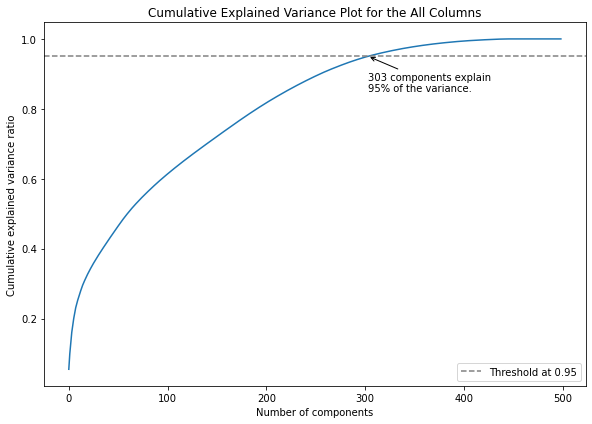

In [37]:
plot_pca(scaled_population_df, scaled_population_df.columns, "All Columns", 0.95)

In [38]:
pca_full = PCA(n_components=303, random_state=101)
pca_full_array = pca_full.fit_transform(scaled_population_df)

In [39]:
max_clusters = 20
sum_of_squared_distances = []
silhouette_scores = []
cluster_labels_list = []

for n_clusters in range(2, max_clusters+1):
    start_time = datetime.now()
    
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=101)
    
    # Fit on the population dataset
    clusterer.fit(pca_full_array)
    
    # Predict on the population dataset
    cluster_labels = clusterer.predict(pca_full_array)
    cluster_labels_list.append(cluster_labels)
    
    # Sum of squared distances for the elbow method
    sum_of_squared_distances.append(clusterer.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_full_array, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    run_time = datetime.now() - start_time
    
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
        "Run time :", run_time
    )

For n_clusters = 2 The average silhouette_score is : 0.04202680775221395 Run time : 2:13:43.075036
For n_clusters = 3 The average silhouette_score is : 0.045279551395371494 Run time : 2:12:03.769286
For n_clusters = 4 The average silhouette_score is : 0.03346663520078652 Run time : 2:09:33.155142
For n_clusters = 5 The average silhouette_score is : 0.03393804345328938 Run time : 2:08:34.643704
For n_clusters = 6 The average silhouette_score is : 0.028815096796112414 Run time : 2:08:08.180560
For n_clusters = 7 The average silhouette_score is : 0.02443866125122618 Run time : 2:08:04.204869
For n_clusters = 8 The average silhouette_score is : 0.023415137368746744 Run time : 2:08:15.112929
For n_clusters = 9 The average silhouette_score is : 0.0226449357947988 Run time : 2:07:58.420356
For n_clusters = 10 The average silhouette_score is : 0.019151801440526472 Run time : 2:07:44.261967
For n_clusters = 11 The average silhouette_score is : 0.02036641027338441 Run time : 2:07:40.944703
For n

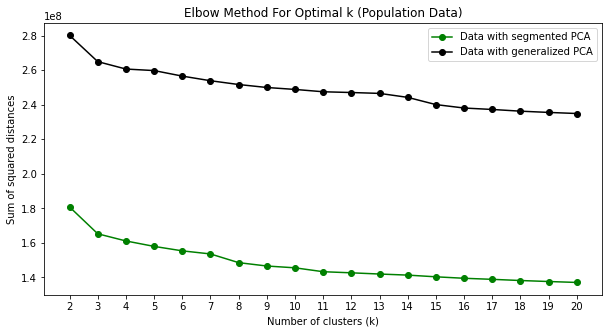

In [42]:
# Elbow Method Visualization
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), pca_sum_of_squared_distances, marker='o', color='green', label='Data with segmented PCA')
plt.plot(range(2, max_clusters+1, 1), sum_of_squared_distances, marker='o', color='black', label='Data with generalized PCA')
plt.xticks(np.arange(2, max_clusters+1, 1))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k (Population Data)')
plt.legend()
plt.show();

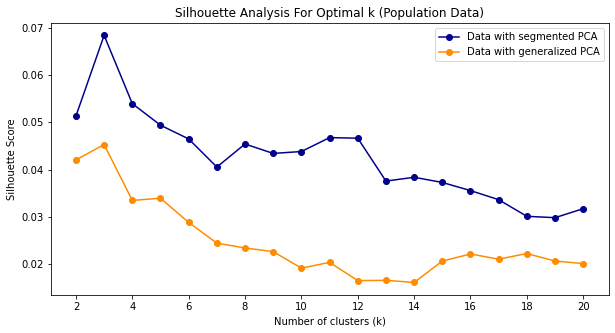

In [43]:
# Silhouette Scores Analysis Visualization:
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), pca_silhouette_scores, marker='o', color='darkblue', label='Data with segmented PCA')
plt.plot(range(2, max_clusters+1, 1), silhouette_scores, marker='o', color='darkorange', label='Data with generalized PCA')
plt.xticks(np.arange(2, max_clusters+1, 2))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k (Population Data)')
plt.legend()
plt.show();

__Analysis__: Looking at the two graphics above we can see that in terms of building clusters, the dataset with the segmented PCA works better than the generalized PCA at 95% of explained variance. Nevertheless, neither one nor the other shows a clear elbow. The silhouette analysis is also not that high (near 0), which means that on average the points are not clearly separable into their own clusters. In other words, the clusters may include points, which could also belong to other clusters. 

As a final analysis, we can now look at the silhouette plots for a particular subset of clusters: 3, 4, 6 and 8. This analysis will only be done for the segmented PCA dataset, because it had a better performance. Looking at the graphics above we can see that `k=3` seems to be the better choice, but in this next analysis we are aiming to look for 3 things:

1. The width of each cluster should be similar.
2. The distribution of each cluster should be above the average of the silhouette scores.
3. There should not be any negative scores withing a cluster since this can indicate that some rows were misclassified.

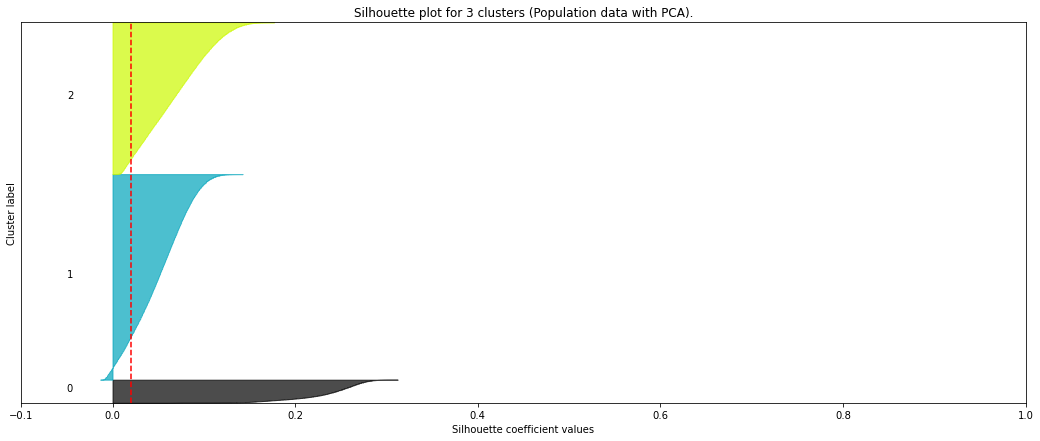

In [44]:
plot_silhouette_plot(pca_population, "Population data with PCA", 3, pca_cluster_labels_list)

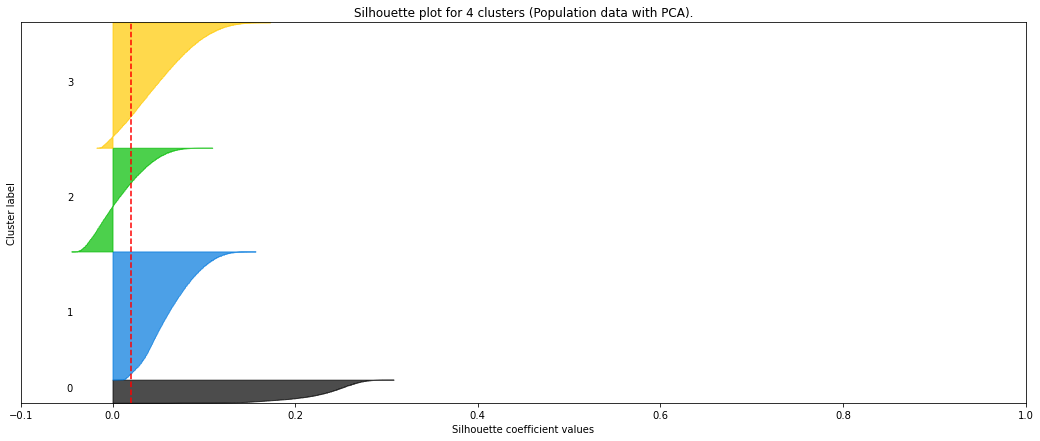

In [45]:
plot_silhouette_plot(pca_population, "Population data with PCA", 4, pca_cluster_labels_list)

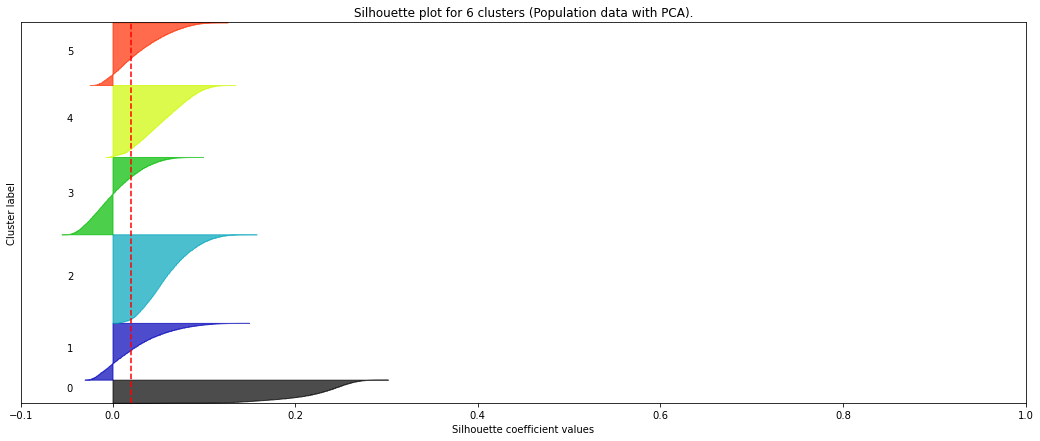

In [46]:
plot_silhouette_plot(pca_population, "Population data with PCA", 6, pca_cluster_labels_list)

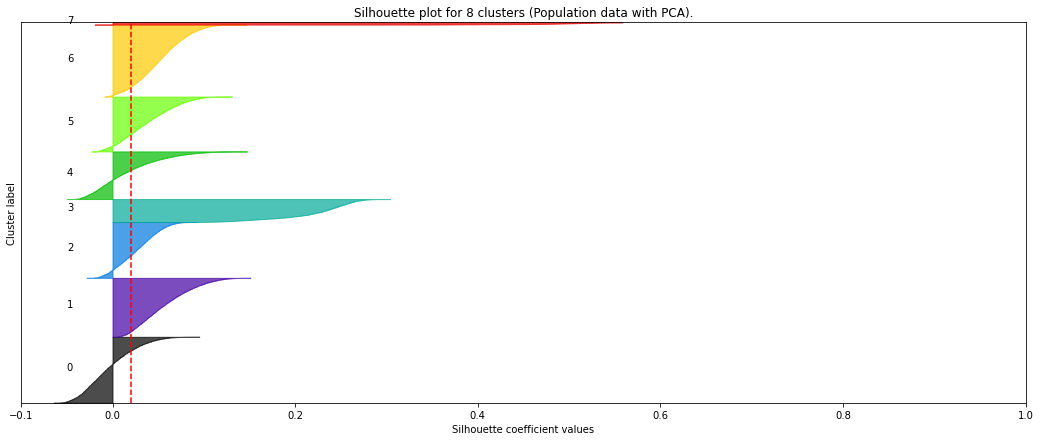

In [47]:
plot_silhouette_plot(pca_population, "Population data with PCA", 8, pca_cluster_labels_list)

__Final analysis__: It is not that easy to make a good decision here because the silhouette plots do not show a clear separation of clusters neither a good distribution at any given value of k. To aid this decision a __domain expert__ could be included as a 4th dimension for adding some more context into the analysis. 

I decided to go with `k=4` because it seems like a good trade-off in the number of clusters and the scores. Nevertheless, this is not a perfect segmentation because we can see some error in one of the clusters and the width is not uniform across all clusters. Still, comparing to the rest it seems to be the best segmentation possible. Also looking at the first two graphics, again, it may be not the best decision, but in combination it may be a good trade-off.

### 1.2.2 Cluster Analysis
Using the number of `k=4`, we can now fit the final clustering model onto the population data and predict for both datasets. The next step is to look at the distribution of clusters and compare them. This will help us find clusters that may be overrepresented in our customer's data when comparing to the population, which in turn should be the target of a new mail campaign. In summary:
- __Target customers__ are the ones where the cluster's proportion is higher in the customer's dataset.
- __Non-target customers__ are the ones where the cluster's proportion is smaller in the customer's dataset.

The logic behind this is based on the principle of over-representation and understanding the current customer base using past data. 

In [32]:
# Create the model with the chosen value of K and fit it on the population dataset
k = 4
clusterer = KMeans(n_clusters=k, n_init="auto", random_state=101)
clusterer.fit(pca_population)

KMeans(n_clusters=4, n_init='auto', random_state=101)

Here we can apply the same data processing as before using the same models fitted for the population to keep the same characteristics of the data

In [33]:
# Scale the data using the same scaler from the population dataset
scaled_customers_array = sc.transform(customers_df)
scaled_customers_df = pd.DataFrame(scaled_customers_array, columns=customers_df.columns)

# Fit the PCA using the same models from the population dataset
pca_c_person_array = pca_person.transform(scaled_customers_df[person_cols])
pca_c_hh_array = pca_hh.transform(scaled_customers_df[hh_cols])
pca_c_microcell_array = pca_microcell.transform(scaled_customers_df[microcell_cols])
pca_c_PLZ8_array = pca_PLZ8.transform(scaled_customers_df[PLZ8_cols])
pca_c_rest_array = pca_rest.transform(scaled_customers_df[rest_cols])

pca_customers = np.hstack((pca_c_person_array, pca_c_hh_array, pca_c_microcell_array, pca_c_PLZ8_array, pca_c_rest_array))
pca_customers.shape

(139840, 135)

In [34]:
# Get the clusters for the population and the customers
population_clusters = clusterer.predict(pca_population)
customers_clusters = clusterer.predict(pca_customers)

In [35]:
# Get the number of individuals per cluster and their proportions for the population dataset
n_clusters_population, counts_clusters_population = np.unique(population_clusters, return_counts=True)
n_clusters_population += 1

# Convert the stats into a dataframe
population_clusters_df = pd.DataFrame({
    'Count (Population)': counts_clusters_population,
    'Proportion (Population)': counts_clusters_population / len(population_clusters)
}, index=n_clusters_population)

# Get the number of individuals per cluster and their proportions for the customers dataset
n_clusters_customers, counts_clusters_customers = np.unique(customers_clusters, return_counts=True)
n_clusters_customers+=1

customers_clusters_df = pd.DataFrame({
    'Count (Customers)': counts_clusters_customers,
    'Proportion (Customers)': counts_clusters_customers / len(customers_clusters)
}, index=n_clusters_customers)


# Merge the two dataframes
clusters_proportions_df = pd.concat([population_clusters_df,customers_clusters_df], axis=1)
clusters_proportions_df = clusters_proportions_df.reset_index().rename(columns={"index":"Cluster"})
clusters_proportions_df["Proportion Difference"] = clusters_proportions_df["Proportion (Customers)"] - clusters_proportions_df["Proportion (Population)"]
clusters_proportions_df

,Cluster,Count (Population),Proportion (Population),Count (Customers),Proportion (Customers),Proportion Difference
0,1,37331,0.060801,6051,0.043271,-0.017530
1,2,199463,0.324863,16104,0.115160,-0.209703
2,3,162726,0.265030,70611,0.504941,0.239911
3,4,214471,0.349306,47074,0.336628,-0.012679


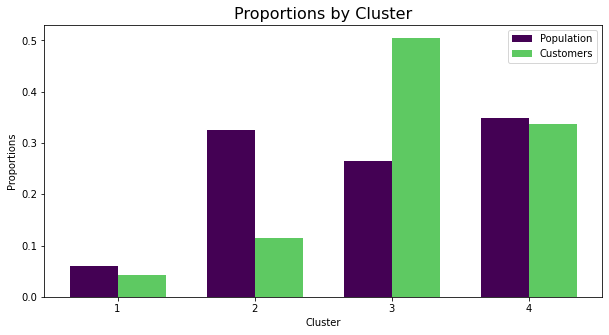

In [36]:
# Plot the clusters proportions
##############################################
# Set the positions and width for the bars
width = 0.35
ind = np.arange(len(clusters_proportions_df['Cluster']))

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# Create bars for Proportions
p1 = ax.bar(ind - width/2, clusters_proportions_df['Proportion (Population)'], width, label='Population', color='#440154')
p2 = ax.bar(ind + width/2, clusters_proportions_df['Proportion (Customers)'], width, label='Customers', color='#5ec962')

# Set labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportions')
ax.set_title('Proportions by Cluster',  fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(clusters_proportions_df['Cluster'])
ax.legend()

# Display the plot
plt.show()

__Analysis__: Now that we have our cluster distribution, we can see that the focus of the campaign should be done for cluster 2, and we should avoid putting extra focus on cluster 1. For clusters 1 and 3, the difference is marginal so we should not put too much attention on those. The next step is to get the centroids' information for each column of the customer's dataset so we can understand the customer segmentation.

In [37]:
# Extract cluster centroids in PCA space
centroids_pca = clusterer.cluster_centers_

# Split the centroids based on the number of components for each PCA model
centroids_pca_person = centroids_pca[:, :pca_person.n_components_]
centroids_pca_hh = centroids_pca[:, pca_person.n_components_: pca_person.n_components_ + pca_hh.n_components_]
centroids_pca_microcell = centroids_pca[:, pca_person.n_components_ + pca_hh.n_components_: pca_person.n_components_ + pca_hh.n_components_ + pca_microcell.n_components_]
centroids_pca_PLZ8 = centroids_pca[:, pca_person.n_components_ + pca_hh.n_components_ + pca_microcell.n_components_: pca_person.n_components_ + pca_hh.n_components_ + pca_microcell.n_components_ + pca_PLZ8.n_components_]
centroids_pca_rest = centroids_pca[:, pca_person.n_components_ + pca_hh.n_components_ + pca_microcell.n_components_ + pca_PLZ8.n_components_:]

# Inverse PCA transformation
centroids_person = pca_person.inverse_transform(centroids_pca_person)
centroids_hh = pca_hh.inverse_transform(centroids_pca_hh)
centroids_microcell = pca_microcell.inverse_transform(centroids_pca_microcell)
centroids_PLZ8 = pca_PLZ8.inverse_transform(centroids_pca_PLZ8)
centroids_rest = pca_rest.inverse_transform(centroids_pca_rest)

# Concatenate these groups to get the full dataset in the scaled space
centroids_scaled = np.hstack([centroids_person, centroids_hh, centroids_microcell, centroids_PLZ8, centroids_rest])

# Apply the inverse transformation of the scaler to get the centroids in the original space
centroids_original = sc.inverse_transform(centroids_scaled)

# Convert to a DataFrame
df_centroids = pd.DataFrame(centroids_original, columns=population_df.columns)
df_centroids = df_centroids.set_index(np.arange(1, k+1))
df_centroids["PRAEGENDE_JUGENDJAHRE"] = df_centroids["PRAEGENDE_JUGENDJAHRE"].clip(0, 15) # to avoid that centroid gets negative values
df_centroids

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,...,RELAT_AB,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,TITEL_

In [38]:
# Select the clusters of interest and the top 20 identified columns 
top20_columns = ["PRAEGENDE_JUGENDJAHRE", "FINANZ_MINIMALIST", "LP_STATUS_FEIN_10.0", "GREEN_AVANTGARDE",
                 "FINANZ_HAUSBAUER", "LP_STATUS_FEIN_1.0", "LP_FAMILIE_FEIN_1.0", "HH_EINKOMMEN_SCORE", "D19_VERSAND_ONLINE_DATUM",
                 "D19_VERSAND_DATUM", "WOHNDAUER_2008", "KBA13_SITZE_5", "KBA05_MOTOR",
                 "PLZ8_ANTG1", "KBA13_ALTERHALTER_30", "INNENSTADT", "CAMEO_DEUG_2015", "KKK",
                 "CAMEO_INTL_2015_14", "ORTSGR_KLS9"]

# Create dataframes per target group with the centroid analysis
target_group = df_centroids.loc[2, top20_columns]
non_target_group = df_centroids.loc[1, top20_columns]
neutral_group_1 = df_centroids.loc[3, top20_columns]
neutral_group_2 = df_centroids.loc[4, top20_columns]

# Merge all dataframes together
centroids_by_cluster = pd.concat([target_group, non_target_group, neutral_group_1, neutral_group_2], axis=1)
centroids_by_cluster = centroids_by_cluster.rename(columns={1:"Non-Target (C1)", 2:"Target (C2)", 3:"Neutral (C3)", 4:"Neutral (C4)"})

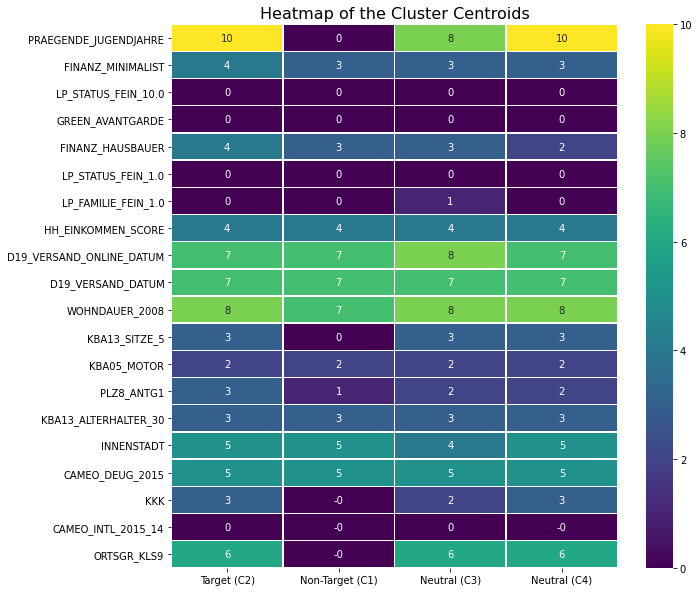

In [39]:
# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(centroids_by_cluster.round(0), cmap='viridis', annot=True, linewidths=.5)
plt.title('Heatmap of the Cluster Centroids', fontsize=16)
plt.show()

# 2. Customer Segmentation Report
This is a part where sometimes data science can be more art than science and it is advisable to have a __domain expert__ involved in this part. Based on the analysis of the previous graphics we can see that the cluster 2 is overrepresented. This should be the customer segment the company should be putting more effort.  On the other side of the coin the company should avoid focusing too much on the type of customers in `cluster 4`.

__Target customer group (Cluster 2)__

- `PRAEGENDE_JUGENDJAHRE = 10`: 80ies - Generation Golf (Mainstream, W).
- `FINANZ_MINIMALIST = 3`: average financial interest.
- `LP_STATUS_FEIN_10.0 = 0`: not a top earner.
- `GREEN_AVANTGARDE = 0`: does not belong to the green avantgarde.
- `FINANZ_HAUSBAUER = 3`: average on the own house.
- `LP_STATUS_FEIN_1 = 0`: not a low-income earner.
- `LP_FAMILIE_FEIN_1 = 0`: not single.
- `HH_EINKOMMEN_SCORE = 4`: average household net income.
- `D19_VERSAND_ONLINE_DATUM = 7`: actuality of the last transaction for the segment mail-order ONLINE: elder than 1.5 years.
- `D19_VERSAND_DATUM = 7`: actuality of the last transaction for the segment mail-order TOTAL: elder than 1.5 years.
- `WOHNDAUER_2008 = 8`: length of residence 7-10 years
- `KBA13_SITZE_5 = 3`: average number of cars with 5 seats in the PLZ8.
- `KBA05_MOTOR = 2`: most common engine size in the microcell is small.
- `PLZ8_ANTG1 = 3`: high share of 1-2 family houses in the PLZ8.
- `KBA13_ALTERHALTER_30 = 3`: average share of car owners below 31 within the PLZ8.
- `INNENSTADT = 5`: distance to the city centre 10-20 km.
- `CAMEO_DEUG_2015 = 5`: active middleclass.
- `KKK = 2`: average purchase power.
- `CAMEO_INTL_2015_14 = 0`: not a consumption-oriented middleclass.
- `ORTSGR_KLS9 = 6`: size of community: 50.001 to 100.000 inhabitants.


__Non-Target customer group (Cluster 4)__

- `PRAEGENDE_JUGENDJAHRE = 9`: 70ies - peace movement (Avantgarde, O+W).
- `FINANZ_MINIMALIST = 3`: average financial interest.
- `LP_STATUS_FEIN_10.0 = 0`: not a top earner.
- `GREEN_AVANTGARDE = 0`: does not belong to the green avantgarde.
- `FINANZ_HAUSBAUER = 3`: average on the own house.
- `LP_STATUS_FEIN_1 = 0`: not a low-income earner.
- `LP_FAMILIE_FEIN_1 = 0`: not single.
- `HH_EINKOMMEN_SCORE = 6`: very low household net income.
- `D19_VERSAND_ONLINE_DATUM = 7`: actuality of the last transaction for the segment mail-order ONLINE: elder than 1.5 years.
- `D19_VERSAND_DATUM = 6`: actuality of the last transaction for the segment mail-order TOTAL: activity elder than 1 year.
- `WOHNDAUER_2008 = 8`: length of residence 7-10 years
- `KBA13_SITZE_5 = 3`: average number of cars with 5 seats in the PLZ8.
- `KBA05_MOTOR = 3`: most common engine size in the microcell is average.
- `PLZ8_ANTG1 = 2`: average share of 1-2 family houses in the PLZ8.
- `KBA13_ALTERHALTER_30 = 3`: average share of car owners below 31 within the PLZ8.
- `INNENSTADT = 3`: distance to the city centre 3-5 km.
- `CAMEO_DEUG_2015 = 6`: low-consumption middleclass.
- `KKK = 2`: high purchase power.
- `CAMEO_INTL_2015_14 = 0`: not a consumption-oriented middleclass.
- `ORTSGR_KLS9 = 5`: size of community: 20.001 to 50.000 inhabitants.


__Final Analysis__:
As we can see above in the centroid analysis some values are the same across the clusters, which shows what we already saw previously that it is not possible to create clear separations of the data. Some values simply overlap with other clusters.

With this in min based on the results above we can describe the target customers as people:
- Between their 50-60s considered comfortable hedonists for whom fashion and brands have replaced political attitudes and the desire for revolution.
- That are not singles and live in higher-density suburbs, where the share of 1-2 family houses is higher than average (probably couples with no kids).
- That generaly actively consume mainstream products and do not put too much attention on environment-oriented products.

# 3. Model Deployment

In [40]:
# dump scaler
dump(sc, 'models\\population_scaler.joblib')

# dump the individual PCA models
dump(pca_person, 'models\\population_pca_person.joblib')
dump(pca_hh, 'models\\population_pca_hh.joblib')
dump(pca_microcell, 'models\\population_pca_microcell.joblib')
dump(pca_PLZ8, 'models\\population_pca_PLZ8.joblib')
dump(pca_rest, 'models\\population_pca_rest.joblib')

# dump the individual lists for the group of columns
dump(person_cols, 'models\\person_cols.joblib')
dump(hh_cols, 'models\\hh_cols.joblib')
dump(microcell_cols, 'models\\microcell_cols.joblib')
dump(PLZ8_cols, 'models\\PLZ8_cols.joblib')
dump(rest_cols, 'models\\rest_cols.joblib')

# dump the cluster
dump(clusterer, 'models\\population_clusterer.joblib')

['models\\population_clusterer.joblib']